## Imports

In [1]:
import numpy as np


import torch



if torch.cuda.is_available():
    DEVICE = 'cuda'
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    DEVICE = 'cpu'

print('Using {}'.format(DEVICE))

INPUT_SIZE = 28*28
BATCH_SIZE = 32
SEQ_LENGTH = 9


import mnist
import plot
import Bathtub

Using cpu


## Set up hyperparameters & load training data
In general we see results for any $\beta$

In [2]:
log_betas =  [0.0] + list(np.logspace(-10, 0, 11))
betas = list(np.linspace(0, 1, 11).round(1)) # linear scale

training_set, validation_set, test_set = mnist.load(val_ratio=0.0)

HIDDEN_SIZE = 64

## Analysis: term (c)
We analyse term (c): the magnitude of the synaptic weights and presynaptic activity, i.e., suppose we have the model output at time step $t$, then we define the loss at timestep $t$ as:
$$ Loss =  \sum_t  \left(\frac{1}{n^2}\sum_k^n \sum_j^n \beta|w_{kj}| + \frac{1}{n} \sum_i^n(1-\beta)|a_i^t|\right)$$
Where $n$ denotes the number of units in the network.

In [3]:
term = 'c'
tubs, train_losses, test_losses = [], [], []
log_tubs, log_train, log_test = [], [], []

### load bathtubs and retrieve train & test loss performance at final epoch

In [4]:
for beta in log_betas:
    log_tub = Bathtub.State(
            activation_func=torch.nn.ReLU(),
            optimizer=torch.optim.Adam,
            lr=1e-4,
            beta=beta,
            input_size=INPUT_SIZE,
            hidden_size=INPUT_SIZE + HIDDEN_SIZE,
            title="bathtub/64u-relu-weight-act-l1-"+str(term)+'-'+str(beta),
            term=term,
            device=DEVICE)

    log_tub.load()
    log_train.append(log_tub.results['train loss'][-1])
    log_test.append(log_tub.results['test loss'][-1])
    log_tubs.append(log_tub)

for beta in betas:
    tub = Bathtub.State(
            activation_func=torch.nn.ReLU(),
            optimizer=torch.optim.Adam,
            lr=1e-4,
            beta=beta,
            input_size=INPUT_SIZE,
            hidden_size=INPUT_SIZE + HIDDEN_SIZE,
            title="bathtub/64u-relu-weight-act-l1-"+str(term)+'-'+str(beta),
            term=term,
            device=DEVICE)

    tub.load()
    train_losses.append(tub.results['train loss'][-1])
    test_losses.append(tub.results['test loss'][-1])
    tubs.append(tub)
    


### display training losses over beta
Note that in this instance a lower loss does not necessarily translate into better results

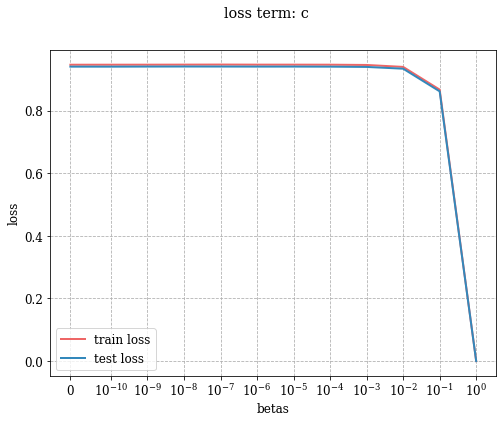

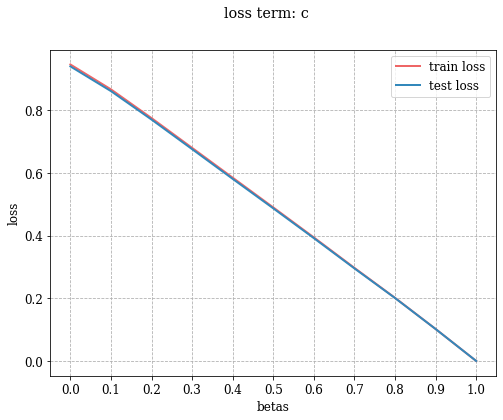

In [5]:
plot.beta_loss(log_betas, log_train, log_test, title=term, scale='log')
plot.beta_loss(betas, train_losses, test_losses, title=term)

### display mean absolute presynaptic and postsynaptic activity of final time step
here the mean absolute presynaptic activity is defined as:
$$ \frac{1}{n} \sum_{i}|a_i|$$
Where $a_i$ is the presynaptic activity of a unit $i$ and $n$ denotes the number of units. 
The global median denotes the median image of the entire data set, while the global median is the mean over the median images of each category. 
The mean postsynaptic activity is defined as:
$$ \frac{1}{n} \sum_{i}|h_i|$$
Where $h_i = ReLU(a_i)$. 

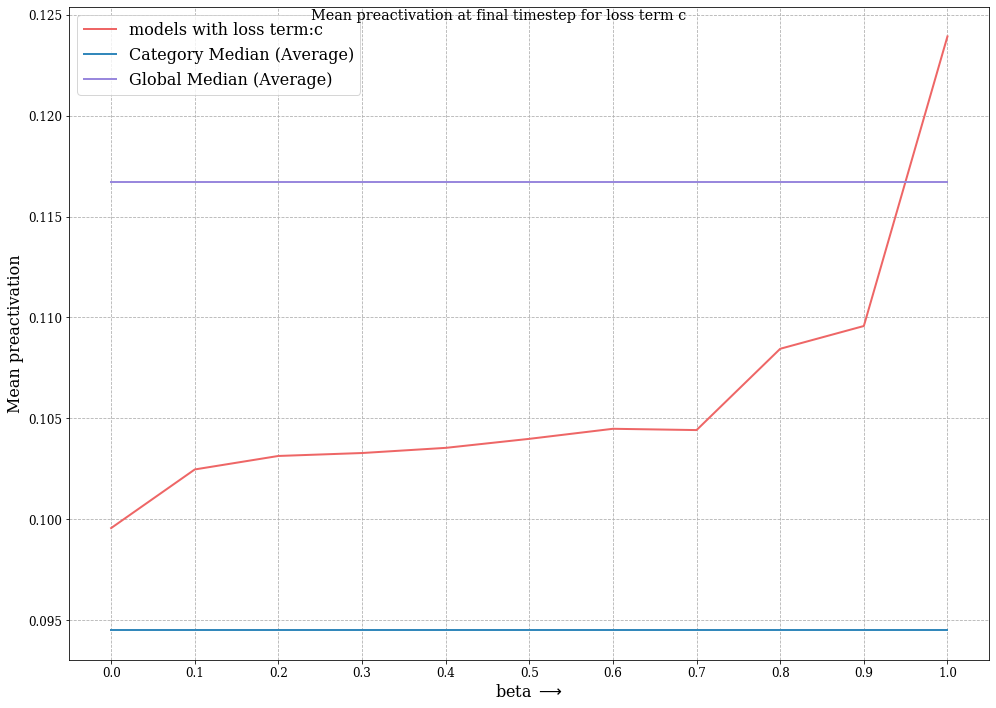

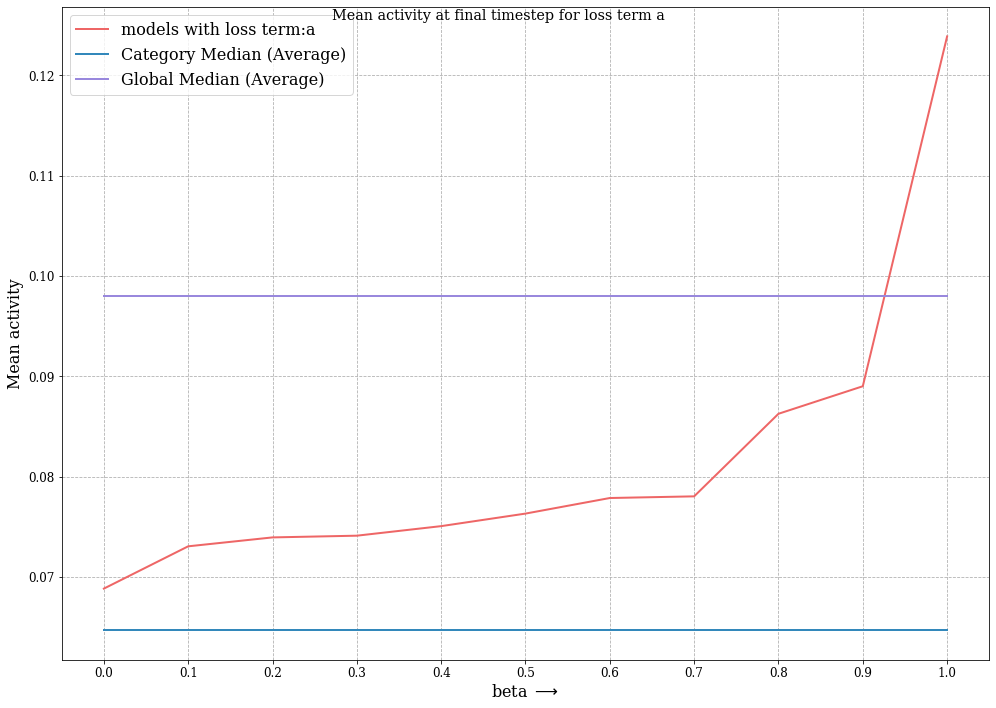

In [6]:
#plot.final_mea(log_betas, log_tubs, training_set, test_set, title=term, scalex='log')
plot.final_mea(betas, tubs, training_set, test_set, title=term)
plot.final_mea(betas, tubs, training_set, test_set, activity='post')

### display mean synaptic transmission (t=9)
the real synaptic transmission at time step $t$ is defined as:
$$ s_t = \frac{1}{n} \sum_{i} \sum_{j} |w_{ji}||h_i^{t-1}|$$
Where $h_i^{t-1}$ is the postsynaptic unit activity of unit i at timestep $t-1$, $w_{ji}$ is a presynaptic connection from unit $j$ to $i$
The respective median transmissions are defined by computing the median images and taking the absolute sum i.e.:
$$s_{med} = \frac{1}{n} \sum_{i} |x_i|$$
Where $x_i$ is a pixel of either the category or global median image and $n$ are the number of units in the network. 

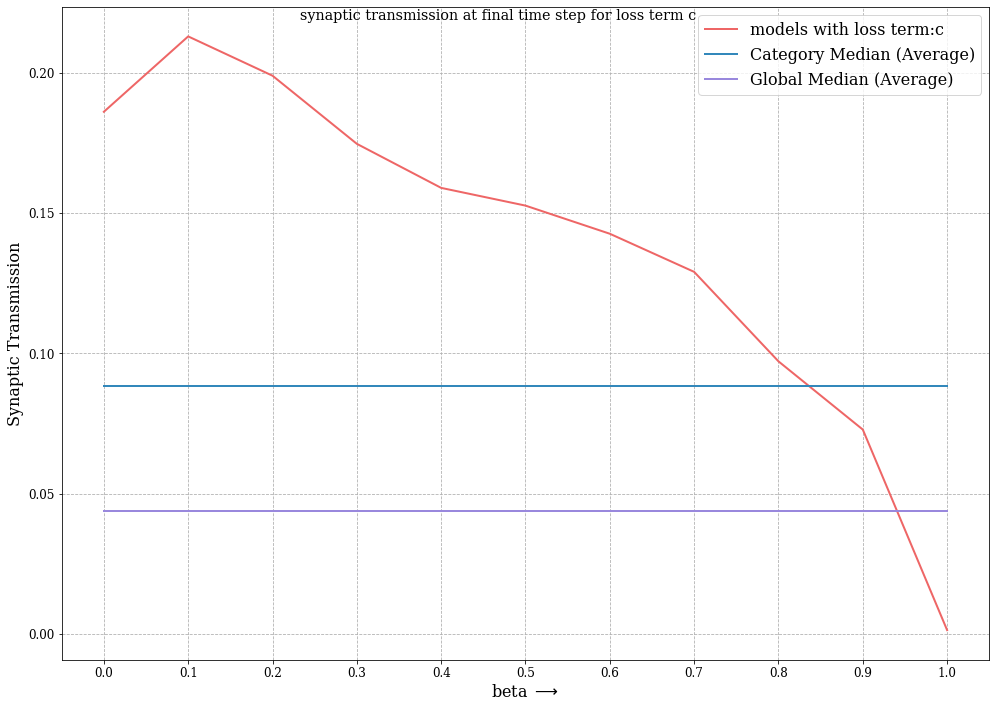

In [7]:
#plot.final_synaptrans(log_betas, log_tubs, training_set, test_set, title=term, scale='log')
plot.final_synaptrans(betas, tubs, training_set, test_set, title=term)

### display mean absolute activity over time
All betas satisfy the prediction input distinction so we highlight  $\beta \in[0,0.1,0.2, 1]$

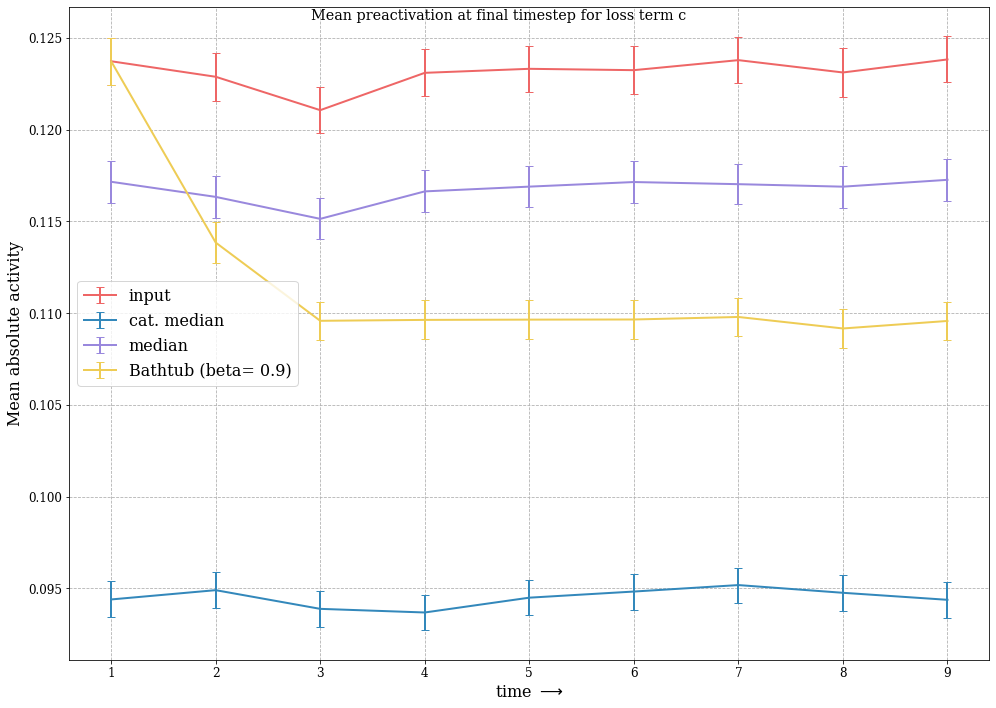

In [8]:
plot.mean_activity([betas[-2]],[tubs[-2]], training_set, test_set, title=term)

### display synaptic transmission over time
Notable observation is that for $\beta=0$ the synaptic transmission is 0. 

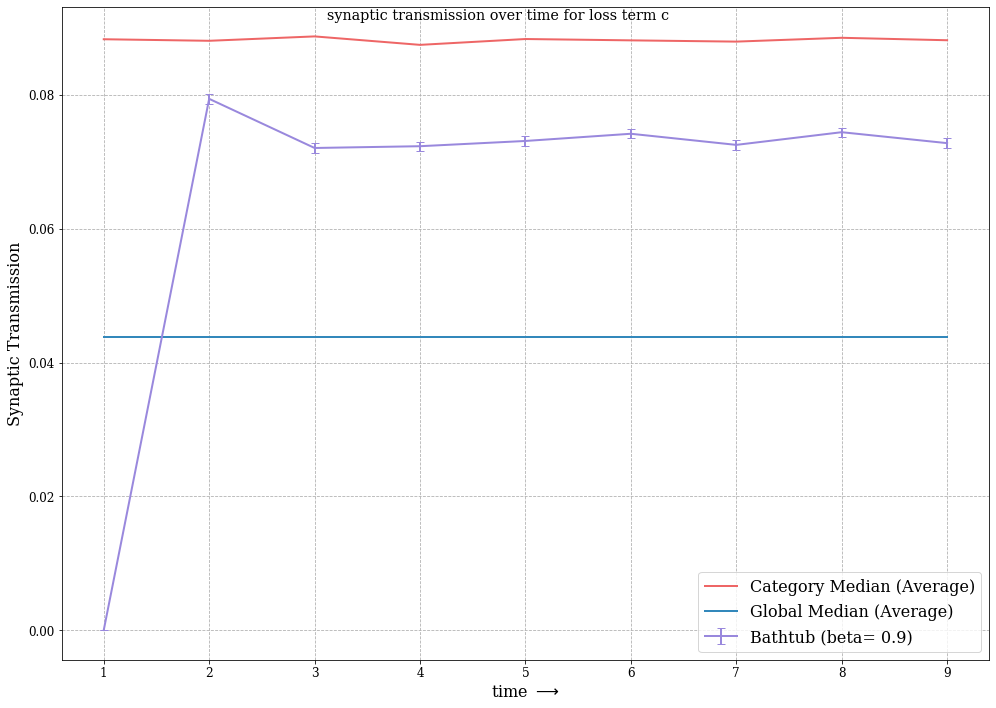

In [9]:
plot.mean_synaptrans([betas[-2]], [tubs[-2]], training_set, test_set, title=term)

### display input & prediction drive
In the following panes we show input and prediction drive for several betas, input and prediction drive are defined as:
$$<x^+> = \frac{1}{n} \sum_b ReLU(\textbf{x}^{t = 9})$$
$$<p^+> = \frac{1}{n} \sum_b ReLU(\textbf{p}^{t = 9})$$
Where $b$ is a sum over the batches, $\textbf{x}^{t = 9}$ is the input batch at the final time step and $\textbf{p}^{t=9} = \textbf{W}\cdot\textbf{h}^{t=9-1}$ is the prediction of the units at the final timestep 

From going through the results for all betas, every beta shows a seperation between prediction and input units, the key difference is in the location of the prediction units, below I only show a couple exemplars. 

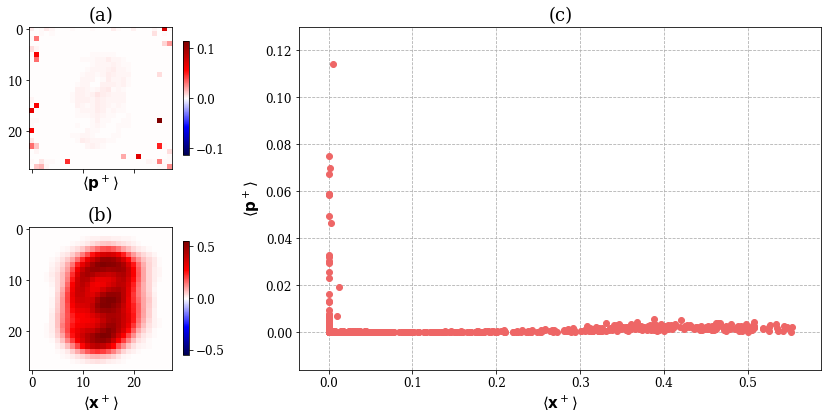

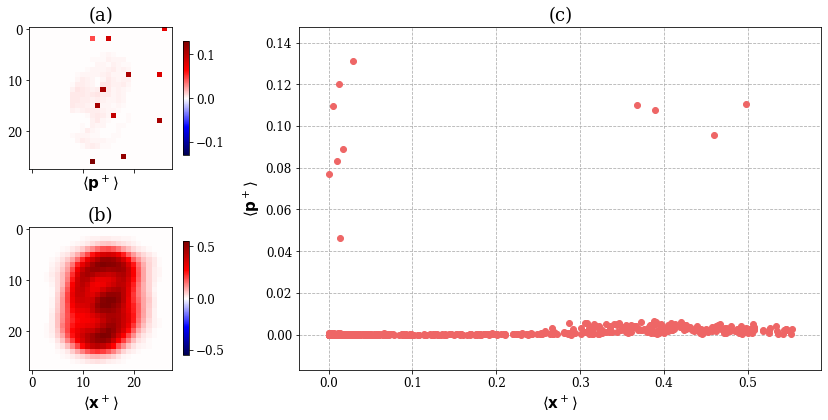

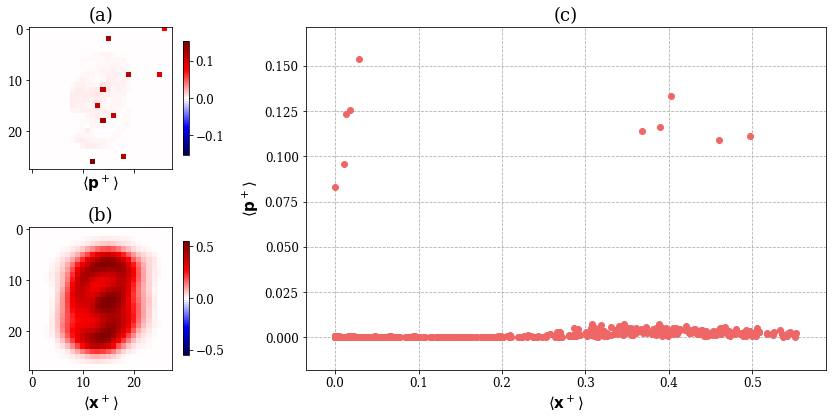

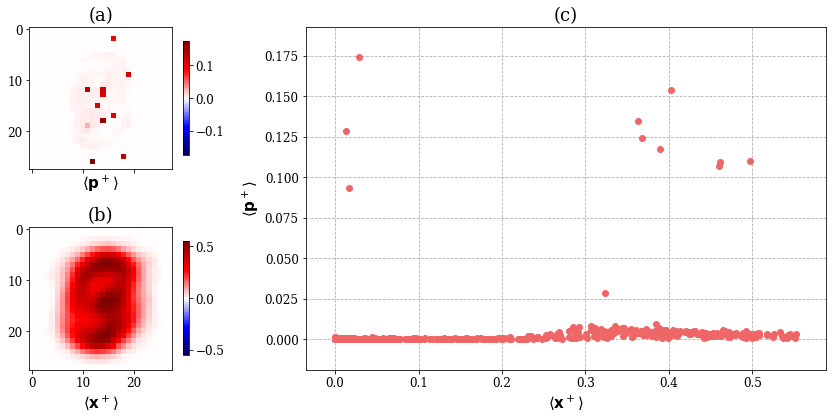

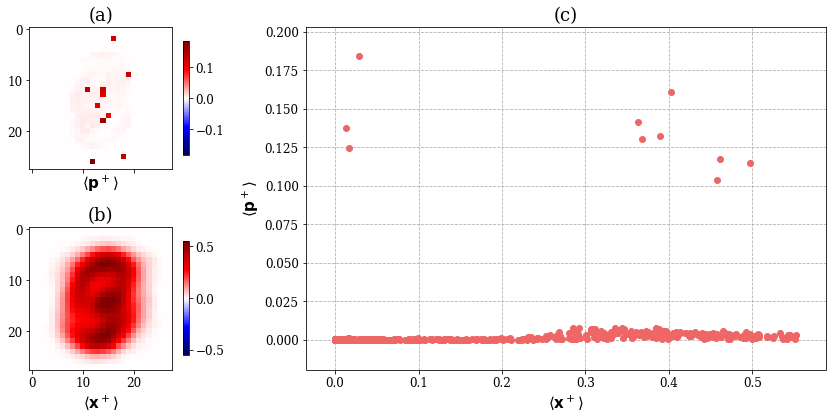

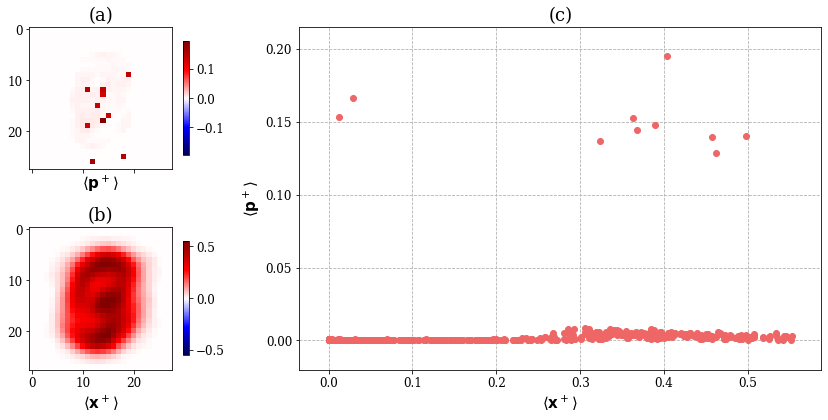

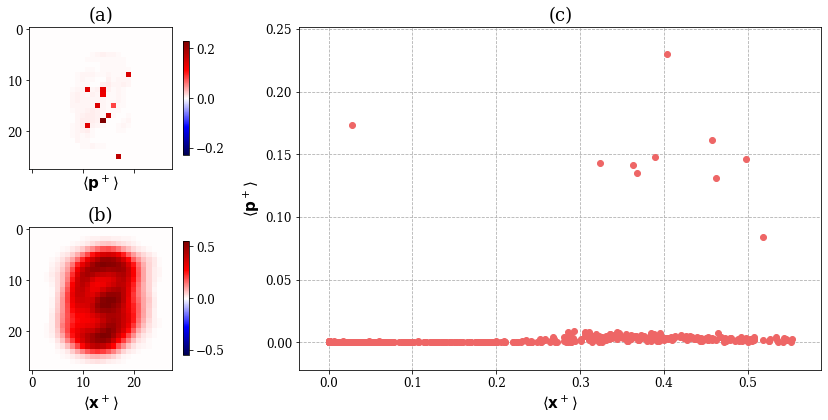

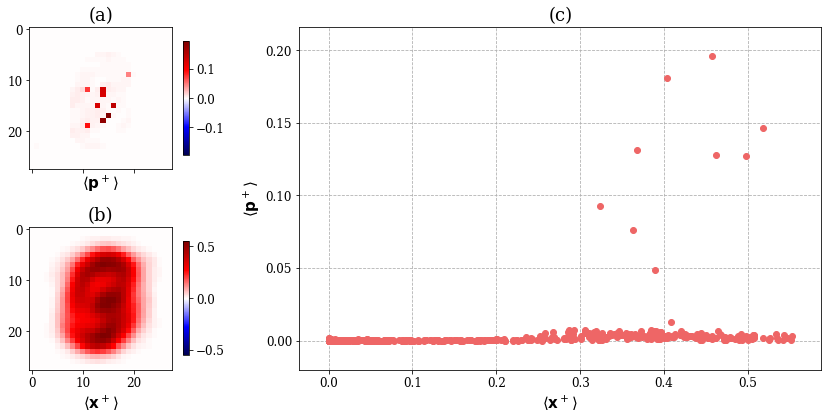

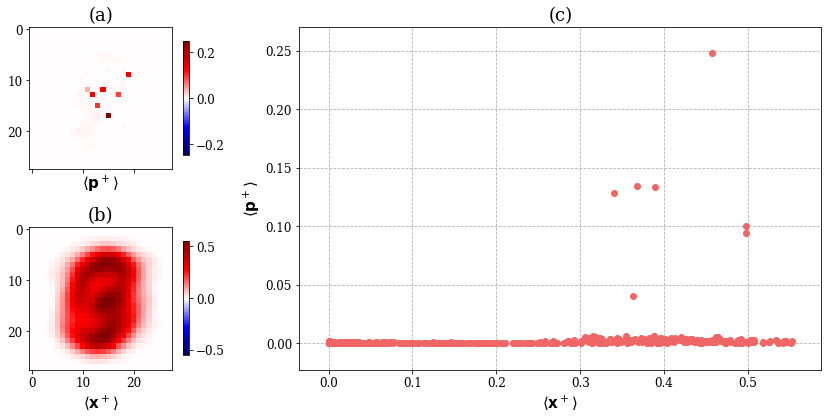

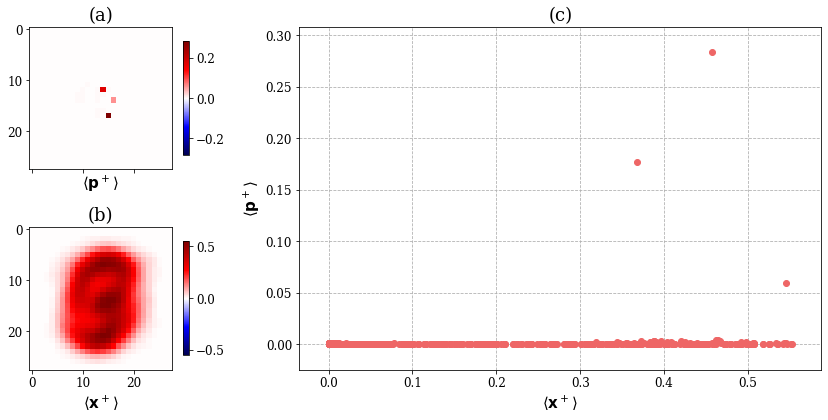

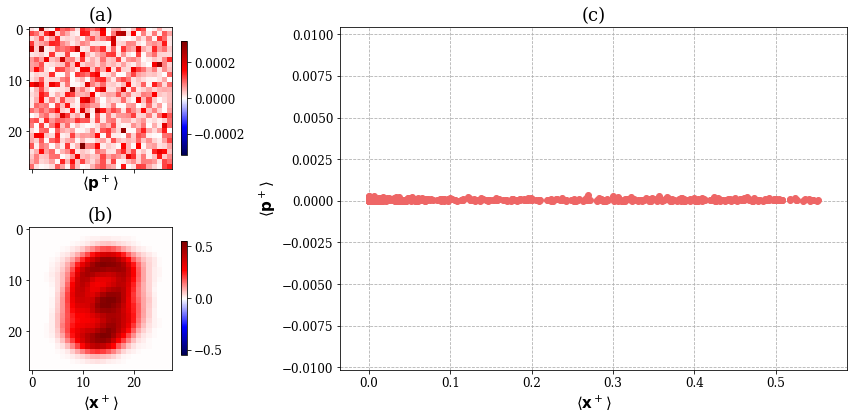

In [11]:
ms_tubs = []
for beta in betas:
    ms = Bathtub.State(activation_func=torch.nn.ReLU(),
            optimizer=torch.optim.Adam,
            lr=1e-4,
            beta=beta,
            input_size=INPUT_SIZE,
            hidden_size=INPUT_SIZE,
            title="bathtub/relu-weight-act-l1-"+str(term)+'-'+str(beta),
            term=term,
            device=DEVICE)
    ms.load()
    ms_tubs.append(ms)
    
for i in range(len(betas)): # check low values of beta and max
    plot.xdrive_pdrive(ms_tubs[i], test_set, save=False)



### Show predictions of best bathtub
Predictions seem to be ok, but since prediction units have input drive for $\beta > 0$ you see some activity in the centre emerge.

In [ ]:
b_tubs = [ms_tubs[0]] + [ms_tubs[4]] + [ms_tubs[-2]] # beta 0 - 0.2 & 1 
for b_tub in b_tubs:
    plot.example_sequence_state(b_tub, test_set, save=False)

In [ ]:
plot.weights_mean_activity(b_tubs[-1], test_set, save=False)